

  Попробуйте обучить нейронную сеть GRU/LSTM для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

  Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?


In [29]:
!pip install stop-words pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
from string import punctuation

from pymorphy2 import MorphAnalyzer
import re
import nltk
nltk.download('wordnet')
nltk.download("punkt")
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchmetrics

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
max_words = 10000
max_len = 10
num_classes = 1

epochs = 10
batch_size = 512
print_batch_n = 100

In [33]:
dataset_train  = 'drive/MyDrive/Twitter Sentiment Analysis/train.csv'
dataset_test  = 'drive/MyDrive/Twitter Sentiment Analysis/test.csv'
data_train = pd.read_csv(dataset_train, encoding='utf-8')
data_test = pd.read_csv(dataset_test, encoding='utf-8')
data_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [34]:
data_test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [35]:
df_train, df_valid = train_test_split(data_train, test_size=0.3, random_state=42)
df_train.head()

,id,label,tweet
9635,9636,0,summer timeð #summeriscoming #swimming #pic...
2447,2448,0,"dese niggas will show dese otha bitches on fb,..."
16134,16135,0,"""when you are you boost your immune system a..."
18393,18394,0,reading my manuscript and not wanting to stop....
4420,4421,0,baby says he hates me today


In [36]:
df_valid.head()

,id,label,tweet
12227,12228,0,@user âmy mom says my smile is captivatingâ...
14709,14710,0,"in 3 days i will be meeting my sis-n-law, coun..."
19319,19320,0,hating the conservative homophobes using this ...
4308,4309,0,awee if this doesn't #scream #friday #acewe...
24055,24056,0,fathersday #fatherÃ¢ÂÂs #day #god! #ÃÂ« #...


In [37]:
sw = set(stopwords.words('english'))
print(sw)

{'can', 'mustn', 'why', 'that', 'doing', 'aren', 'here', 'me', 'because', 'during', 'out', 'you', 'on', "needn't", "you've", 'mightn', 'didn', "that'll", 'been', 'of', 'only', 'were', 'won', 'am', 'no', 'has', "haven't", 'through', 'an', 'ain', 'the', "mustn't", 're', 'do', 't', 've', 'himself', 'at', 'when', 'how', 'off', 'just', 'more', 'for', 'does', 'under', 'a', 'having', 'between', 'wasn', 'will', 'o', 'isn', 'into', 'in', 'your', 'those', 'as', 'i', 'nor', 'my', 'couldn', 'this', 'after', 'their', 'have', 'with', 'what', 'he', 'against', 'she', 'ourselves', 'while', 'most', 'then', 'above', 'too', 'ours', 'yourself', 'such', "should've", "you're", 'm', 'him', 'shouldn', "hadn't", 'hasn', 'these', "hasn't", 'over', 'than', "don't", 'shan', 'it', 'we', 'ma', 'her', 'same', 'y', 'd', 'up', 'all', 'now', 'once', "shan't", "wouldn't", 'some', 'yours', 'which', 'below', "isn't", 'but', 'whom', 'hadn', 'myself', 'doesn', 'to', 'if', 'itself', 'them', 'our', 's', 'about', "won't", "aren

In [38]:
exclude = set(punctuation)
print(exclude)

{'<', '@', '$', '#', '}', '[', ')', '?', '(', '>', ']', '/', '=', '_', ';', ',', '!', '&', '^', '+', '"', '-', '*', '.', "'", '`', '%', ':', '~', '{', '\\', '|'}


In [39]:
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('donkeys'), lemmatizer.lemmatize('runs')

('donkey', 'run')

In [40]:
#функция преобразования текста
def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = [lemmatizer.lemmatize(w) for w in txt.split() if w not in sw]
    return " ".join(txt)

In [41]:
#преобразование текста в данных
from tqdm import tqdm 
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_valid['tweet'] = df_valid['tweet'].progress_apply(preprocess_text)
data_test['tweet'] = data_test['tweet'].progress_apply(preprocess_text)

100%|██████████| 17197/17197 [00:00<00:00, 18621.97it/s]


In [42]:
#соединение всех обучающих данных в одну строку и приведение к нижнему регистру
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()
#токенизация
tokens = word_tokenize(train_corpus)
tokens[:10]

['summer',
 'timeð\x9f\x8c',
 'summeriscoming',
 'swimming',
 'picoftheday',
 'tattoo',
 'issho',
 'pulsera',
 'fluyendo',
 'â\x80¦']

In [43]:
#отфильтруем
tokens_filtered = [word for word in tokens if word.isalnum()]

In [44]:
#частотное распределение: как часто встречается каждый токен в tokens_filtered
dist = FreqDist(tokens_filtered)
dist

FreqDist({'summer': 377,
          'summeriscoming': 2,
          'swimming': 24,
          'picoftheday': 47,
          'tattoo': 18,
          'issho': 1,
          'pulsera': 1,
          'fluyendo': 2,
          'dese': 8,
          'nigga': 40,
          'show': 229,
          'otha': 1,
          'bitch': 52,
          'fb': 15,
          'snap': 12,
          'nd': 6,
          'twitter': 101,
          'attention': 18,
          'dey': 5,
          'girl': 410,
          'true': 137,
          'boost': 4,
          'immune': 2,
          'system': 26,
          'allow': 20,
          'body': 84,
          'use': 74,
          'energy': 36,
          'reading': 63,
          'manuscript': 1,
          'wanting': 5,
          'stop': 174,
          'good': 599,
          'evening': 65,
          'night': 272,
          'baby': 187,
          'say': 241,
          'hate': 175,
          'today': 742,
          'im': 785,
          'dj': 41,
          'lol': 138,
          'womanof

In [45]:
#(создаем упорядоченные пары (слово, частота) в количестве max_words штук и берем первые элементы пар)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # -1 - padding
len(tokens_filtered_top), tokens_filtered_top[:10]

(9999,
 ['user', 'love', 'day', 'happy', 'u', 'amp', 'time', 'life', 'im', 'today'])

In [46]:
#слово : индекс из tokens_filtered_top
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top)).items()}

In [47]:
#преобразование текста в последовательность
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())  #токенизация
    tokens_filtered = [word for word in tokens if word.isalnum()] #фильтруем (только буквы и цифры)
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word]) #если слово в топе токенов, то добавляем его индекс в результат

    padding = [0] * (maxlen-len(result)) #нули дополняющие до maxlen
    return result[-maxlen:] + padding

In [48]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]], dtype=np.int32)
x_valid = np.asarray([text_to_sequence(text, max_len) for text in df_valid["tweet"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in data_test["tweet"]], dtype=np.int32)

x_train.shape, x_valid.shape, x_test.shape

((22373, 10), (9589, 10), (17197, 10))

In [49]:
torch.from_numpy(x_train[0])

tensor([  39, 6949, 1093,  580, 1375, 6950,    0,    0,    0,    0],
       dtype=torch.int32)

In [50]:
#Dataset
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long() #преобразуем в целочисленный тензор
        self.target = torch.from_numpy(target).long() #преобразуем в целочисленный тензор
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]  #индексация данных
        y = self.target[index]  #индексация целевой переменной
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [51]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = DataWrapper(x_valid, df_valid['label'].values)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True)

In [52]:
for x, l in train_loader:
    print(x.shape, x[0])
    print(l.shape, l[0])
    break

torch.Size([512, 10]) tensor([1617,  597,  594, 1740,  979,  832, 7379,  364, 7380, 1710])
torch.Size([512]) tensor(1)


### GRU

In [53]:
#GRU
class GRUFixedLen(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)

        gru_out, ht = self.gru(x) 

        if self.use_last:
            last_tensor = gru_out[:,-1,:] 
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1) 
    
        out = self.linear(last_tensor)
        
        return torch.sigmoid(out)

In [54]:
model_gru = GRUFixedLen(max_words, 128, 128, use_last=False)
print(model_gru)
print("Parameters:", sum([param.nelement() for param in model_gru.parameters()]))

GRUFixedLen(
  (embeddings): Embedding(10000, 128, padding_idx=0)
  (gru): GRU(128, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 1478273


In [55]:
optimizer = torch.optim.Adam(model_gru.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [56]:
%%time

#обучение модели
model_gru.train()

train_loss_history = []
valid_loss_history = []

train_acc_history_gru = []
valid_acc_history_gru = []

train_acc = torchmetrics.Accuracy()
test_acc = torchmetrics.Accuracy()

for epoch in range(epochs):  
    model_gru.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model_gru(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        
        # подсчет метрики на обучении
        train_acc(outputs.squeeze(), labels)
        
    # выводим статистику о процессе обучения
    model_gru.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {train_acc.compute().item():.3f}', end='. ')

    train_loss_history.append(loss)
    train_acc_history_gru.append(train_acc.compute().item())
    train_acc.reset()
    

    # выводим статистику на тестовых данных

    for j, data in enumerate(valid_loader):
        test_labels = data[1]
        test_outputs = model_gru(data[0])
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        
        # подсчет метрики на тесте
        test_acc(test_outputs.squeeze(), test_labels)
    
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_acc.compute().item():.3f}')
    valid_loss_history.append(test_loss.item())
    valid_acc_history_gru.append(test_acc.compute().item())
    test_acc.reset()
    
print('Training is finished!')


Epoch [1/10]. Step [44/44]. Loss: 0.255. Acc: 0.917. Test loss: 0.487. Test acc: 0.934
Epoch [2/10]. Step [44/44]. Loss: 0.207. Acc: 0.941. Test loss: 0.027. Test acc: 0.942
Epoch [3/10]. Step [44/44]. Loss: 0.129. Acc: 0.950. Test loss: 0.862. Test acc: 0.945
Epoch [4/10]. Step [44/44]. Loss: 0.164. Acc: 0.954. Test loss: 0.390. Test acc: 0.950
Epoch [5/10]. Step [44/44]. Loss: 0.097. Acc: 0.962. Test loss: 0.008. Test acc: 0.953
Epoch [6/10]. Step [44/44]. Loss: 0.077. Acc: 0.968. Test loss: 0.004. Test acc: 0.954
Epoch [7/10]. Step [44/44]. Loss: 0.057. Acc: 0.973. Test loss: 0.010. Test acc: 0.955
Epoch [8/10]. Step [44/44]. Loss: 0.072. Acc: 0.978. Test loss: 0.002. Test acc: 0.956
Epoch [9/10]. Step [44/44]. Loss: 0.047. Acc: 0.979. Test loss: 0.003. Test acc: 0.956
Epoch [10/10]. Step [44/44]. Loss: 0.046. Acc: 0.985. Test loss: 0.001. Test acc: 0.958
Training is finished!
CPU times: user 1min 36s, sys: 828 ms, total: 1min 37s
Wall time: 1min 37s


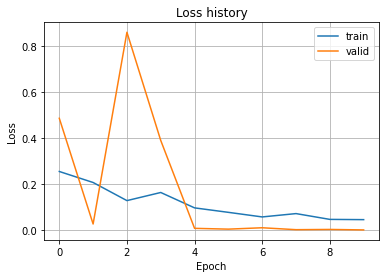

In [57]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()

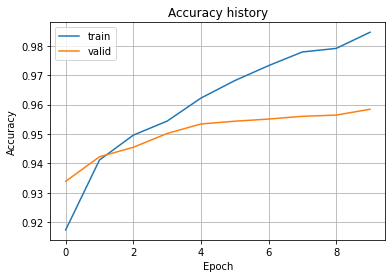

In [58]:
plt.title('Accuracy history')
plt.grid(True)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(train_acc_history_gru, label='train')
plt.plot(valid_acc_history_gru, label='valid')
plt.legend()

### LSTM

In [65]:
#LSTM
class LSTMFixedLen(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)

        lstm_out, ht = self.lstm(x) 

        if self.use_last:
            last_tensor = lstm_out[:,-1,:] 
        else: 
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        
        return torch.sigmoid(out)


In [66]:
model_lstm = LSTMFixedLen(max_words, 128, 128, use_last=False)
print(model_lstm)
print("Parameters:", sum([param.nelement() for param in model_lstm.parameters()]))

LSTMFixedLen(
  (embeddings): Embedding(10000, 128, padding_idx=0)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 1544321


In [67]:
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [68]:
%%time

#обучение модели
model_lstm.train()

train_loss_history = []
valid_loss_history = []

train_acc_history_lstm = []
valid_acc_history_lstm = []

train_acc = torchmetrics.Accuracy()
test_acc = torchmetrics.Accuracy()

for epoch in range(epochs):  
    model_lstm.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model_lstm(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        
        # подсчет метрики на обучении
        train_acc(outputs.squeeze(), labels)
        
    # выводим статистику о процессе обучения
    model_lstm.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {train_acc.compute().item():.3f}', end='. ')

    train_loss_history.append(loss)
    train_acc_history_lstm.append(train_acc.compute().item())
    train_acc.reset()

    
    # выводим статистику на тестовых данных
    for j, data in enumerate(valid_loader):
        test_labels = data[1]
        test_outputs = model_lstm(data[0])
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        
        # подсчет метрики на тесте
        test_acc(test_outputs.squeeze(), test_labels)

    print(f'Test loss: {test_loss:.3f}. Test acc: {test_acc.compute().item():.3f}')
    valid_loss_history.append(test_loss.item())
    valid_acc_history_lstm.append(test_acc.compute().item())
    test_acc.reset()
    
print('Training is finished!')

Epoch [1/10]. Step [44/44]. Loss: 0.262. Acc: 0.927. Test loss: 0.092. Test acc: 0.934
Epoch [2/10]. Step [44/44]. Loss: 0.175. Acc: 0.938. Test loss: 0.288. Test acc: 0.940
Epoch [3/10]. Step [44/44]. Loss: 0.193. Acc: 0.946. Test loss: 0.527. Test acc: 0.946
Epoch [4/10]. Step [44/44]. Loss: 0.139. Acc: 0.955. Test loss: 0.013. Test acc: 0.949
Epoch [5/10]. Step [44/44]. Loss: 0.140. Acc: 0.960. Test loss: 0.028. Test acc: 0.953
Epoch [6/10]. Step [44/44]. Loss: 0.107. Acc: 0.969. Test loss: 0.003. Test acc: 0.954
Epoch [7/10]. Step [44/44]. Loss: 0.067. Acc: 0.973. Test loss: 1.252. Test acc: 0.956
Epoch [8/10]. Step [44/44]. Loss: 0.077. Acc: 0.978. Test loss: 0.384. Test acc: 0.950
Epoch [9/10]. Step [44/44]. Loss: 0.068. Acc: 0.980. Test loss: 1.437. Test acc: 0.957
Epoch [10/10]. Step [44/44]. Loss: 0.039. Acc: 0.986. Test loss: 0.005. Test acc: 0.955
Training is finished!
CPU times: user 2min 1s, sys: 787 ms, total: 2min 2s
Wall time: 2min 8s


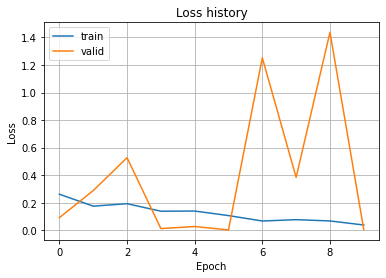

In [69]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()

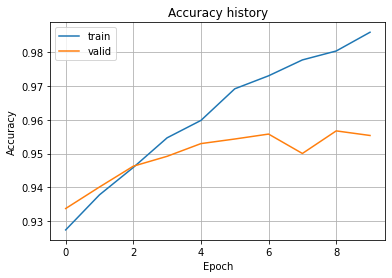

In [70]:
plt.title('Accuracy history')
plt.grid(True)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(train_acc_history_lstm, label='train')
plt.plot(valid_acc_history_lstm, label='valid')
plt.legend()

In [71]:
metrics_result = pd.DataFrame([{'Acc_train': train_acc_history_lstm[-1], 
                                'Acc_test': valid_acc_history_lstm[-1]},
                               {'Acc_train':  train_acc_history_gru[-1],
                                'Acc_test': valid_acc_history_gru[-1]}],
                              index =['LSTM', 'GRU'], 
                              columns =['Acc_train', 'Acc_test'])

metrics_result.sort_values(by='Acc_test', ascending=False)

,Acc_train,Acc_test
GRU,0.984580,0.958390
LSTM,0.985876,0.955366


#### При одних и тех же гиперпараметрах GRU обучается быстрее, чем LSTM. При этом метрики моделей примерно одинаковы.
#### Поскольку метрика на валидации растет немонотонно, то увеличение числа эпох не способствует росту метрик на валидации.
#### Увеличение hidden_dim, embedding_dim, max_words будут способствовать увеличению метрики на валидации